Let's finally solve the problem of getting a clean-looking spectrum from the RTLSDR.

In [22]:
%matplotlib notebook

In [2]:
import matplotlib.pyplot as plt
import rtlsdr
import numpy as np
import time
import RTLSDRTools as rst
from matplotlib.mlab import psd

In [3]:
# Keywords to Scan
f_min = 64e6
f_max = 1700e6
rate_best = 2.4e6
gain = 4
npsd_res = 1024
npsd_avg = 256

In [4]:
psd_array, freq_array = rst.Scan(verbose=True)

Estimated time to scan 115.41258666666667 seconds
Length of scan 0.10922666666666667 seconds
Actual time to scan 122.23139190673828


In [5]:
_, nfreq = psd_array.shape
nfreq_spec = npsd_res * nfreq

<IPython.core.display.Javascript object>


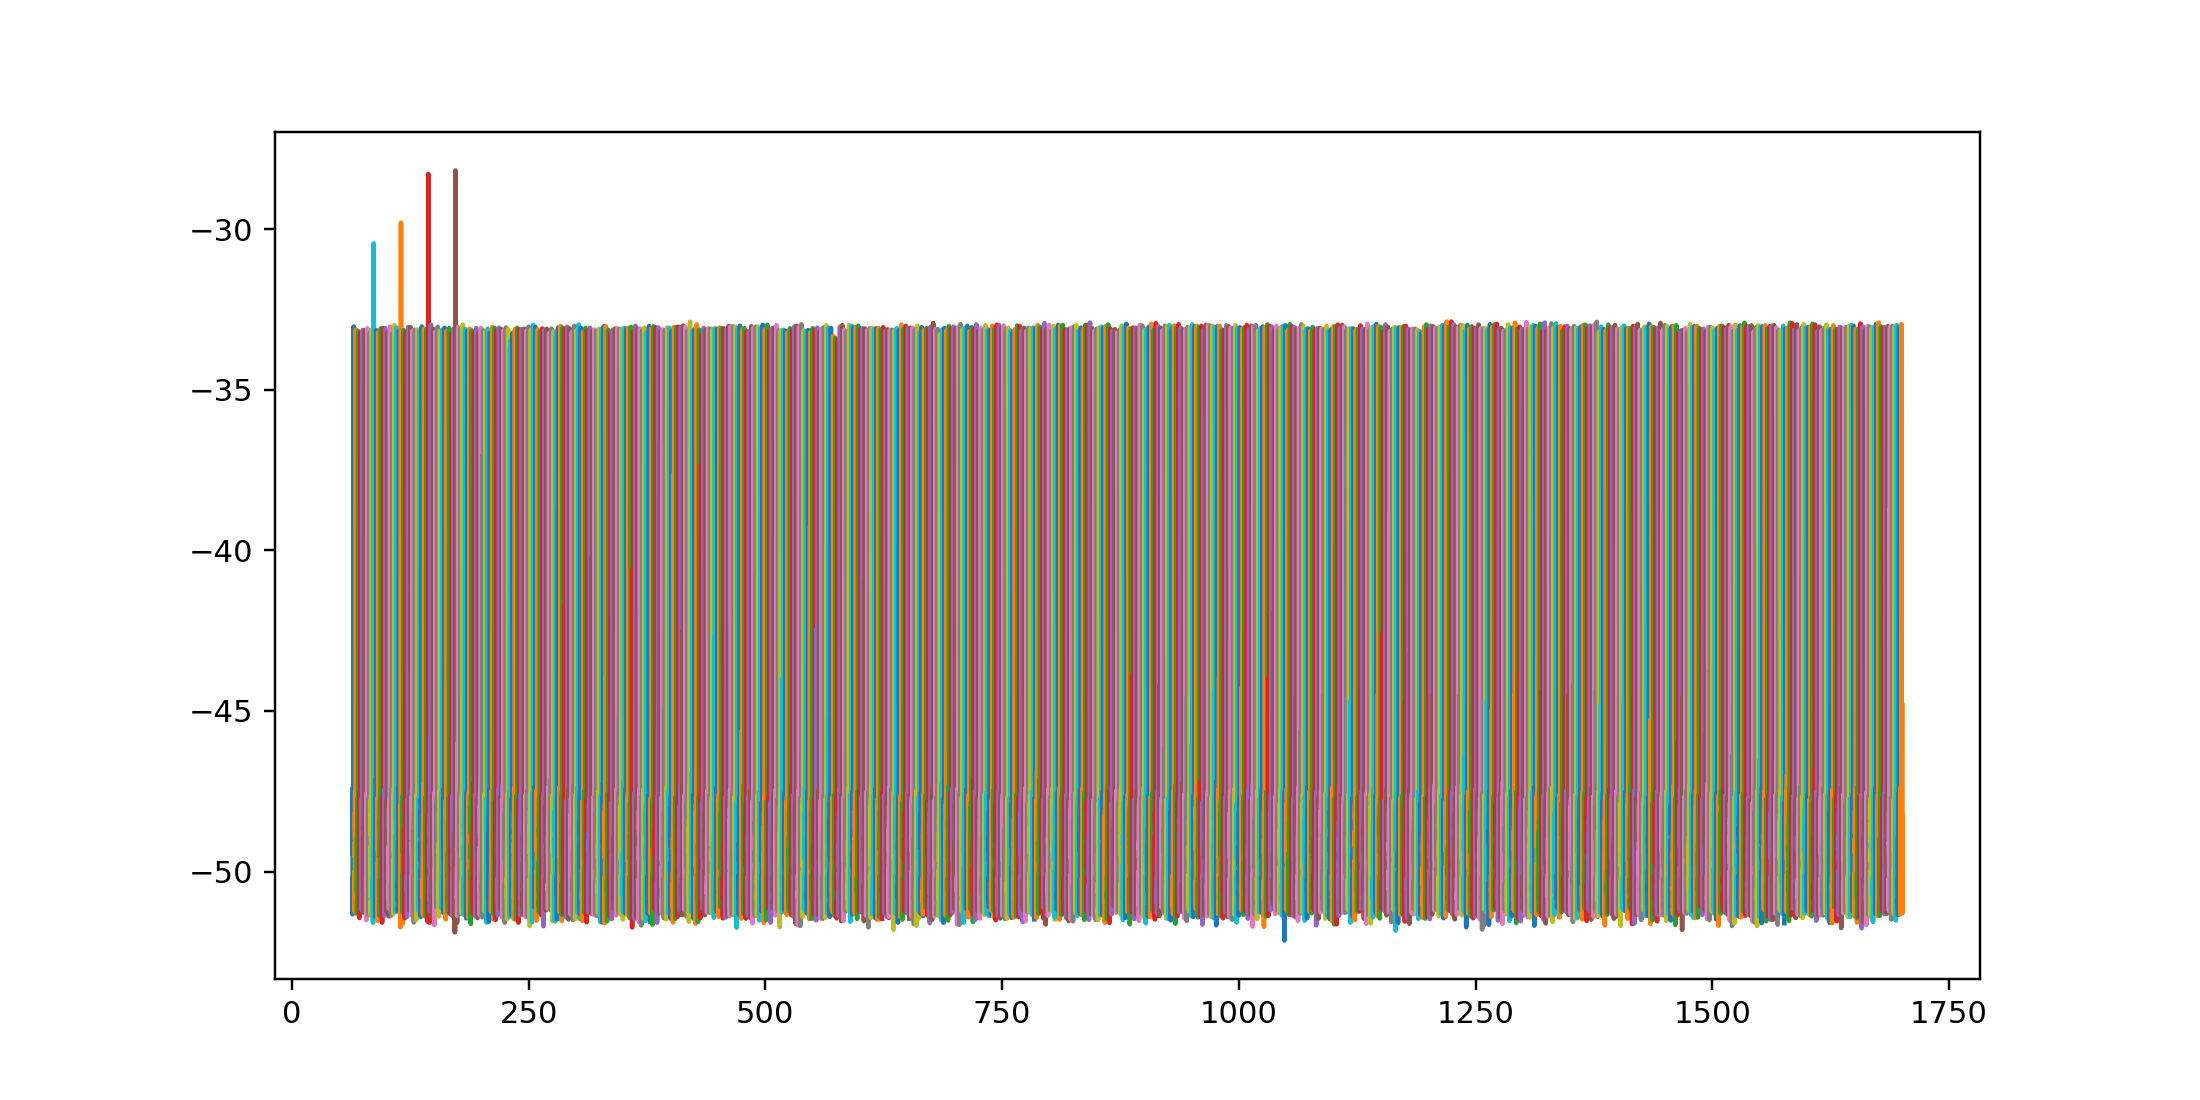

In [23]:
plt.figure(figsize=(10,5))
plt.plot(freq_array, 10.*np.log10(psd_array))
plt.show()

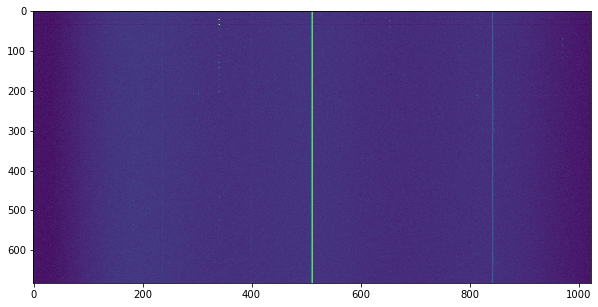

In [7]:
plt.figure(figsize=(10,5))
plt.imshow(np.log10(psd_array).T, aspect='auto', interpolation='none')
plt.show()

In [8]:
bckgrnd = np.median(psd_array,axis=1)
bckgrnd_array = np.outer(bckgrnd,np.ones(nfreq))
bckgrnd_array.shape
# Should really consider fitting for the background and using the fit.  The noise is still evident ...

(1024, 682)

In [9]:
flags = np.ones(npsd_res)
ctr = int(npsd_res/2.)
#flags[ctr-2:ctr+2] = 0.
off = int(0.826*npsd_res)
#flags[off-3:off+2] = 0.
# Some others
pad = 3
bads = [ctr, off, 237, 341, 402]
pad = 3
for bad in bads:
    flags[bad-pad : bad+pad+1] = 0.

flags_array = np.outer(flags,np.ones(nfreq))

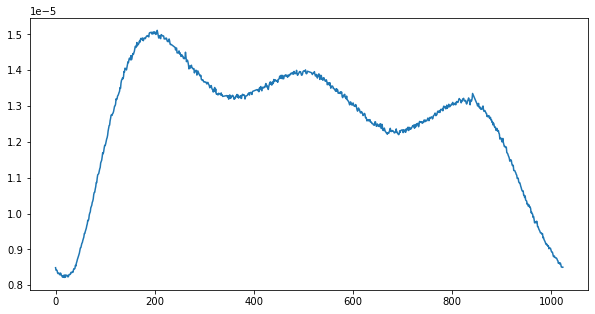

In [10]:
plt.figure(figsize=(10,5))
#plt.plot(bckgrnd)
plt.plot(np.arange(1024)[flags !=0], bckgrnd[flags !=0])
plt.show()

In [11]:
bp_fitted = rst.fit_bp(bckgrnd, flags)
np.savez('bandpass.npz', bandpass=bp_fitted)
bp_array = np.outer(bp_fitted,np.ones(nfreq))

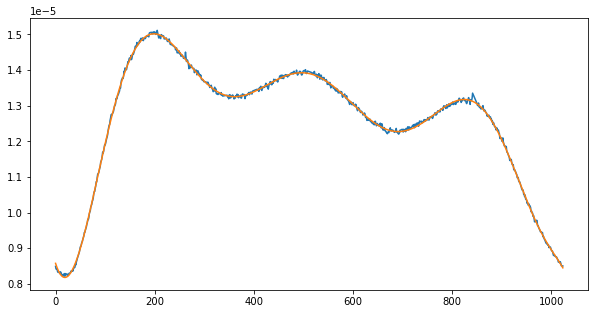

In [12]:
plt.figure(figsize=(10,5))
#plt.plot(bckgrnd)
plt.plot(np.arange(1024)[flags !=0], bckgrnd[flags !=0])
plt.plot(bp_fitted)
plt.show()

/Users/jaguirre/opt/anaconda3/envs/MRT/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


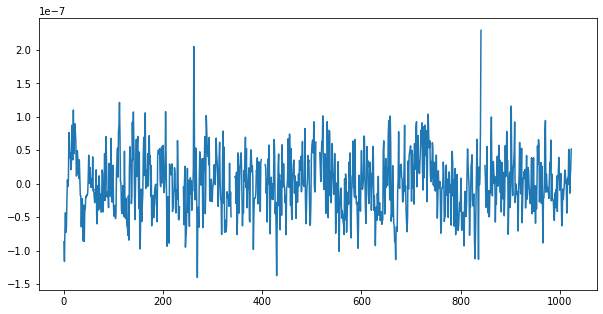

In [13]:
plt.figure(figsize=(10,5))
plt.plot(bckgrnd/flags - bp_fitted)
plt.show()

/Users/jaguirre/opt/anaconda3/envs/MRT/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


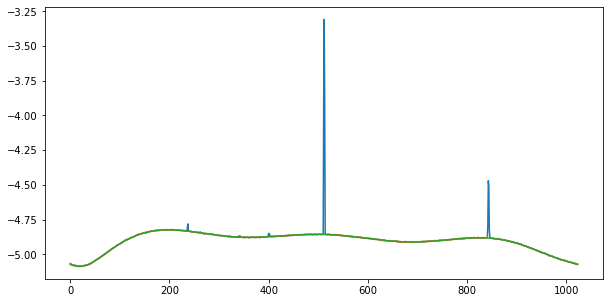

In [14]:
plt.figure(figsize=(10,5))
plt.plot(np.log10(bckgrnd))
plt.plot(np.log10(bckgrnd/flags))
plt.plot(np.log10(bp_fitted))
plt.show()

In [15]:
psd_all = np.reshape((psd_array/bp_array).T,nfreq_spec)
freq_all = np.reshape(freq_array.T,nfreq_spec)
flags_all = np.reshape(flags_array.T,nfreq_spec)

/Users/jaguirre/opt/anaconda3/envs/MRT/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


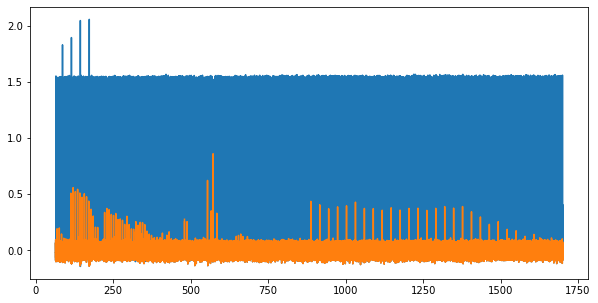

In [16]:
plt.figure(figsize=(10,5))
plt.plot(freq_all,np.log10(psd_all))
plt.plot(freq_all,np.log10(psd_all/flags_all))
plt.show()

<IPython.core.display.Javascript object>


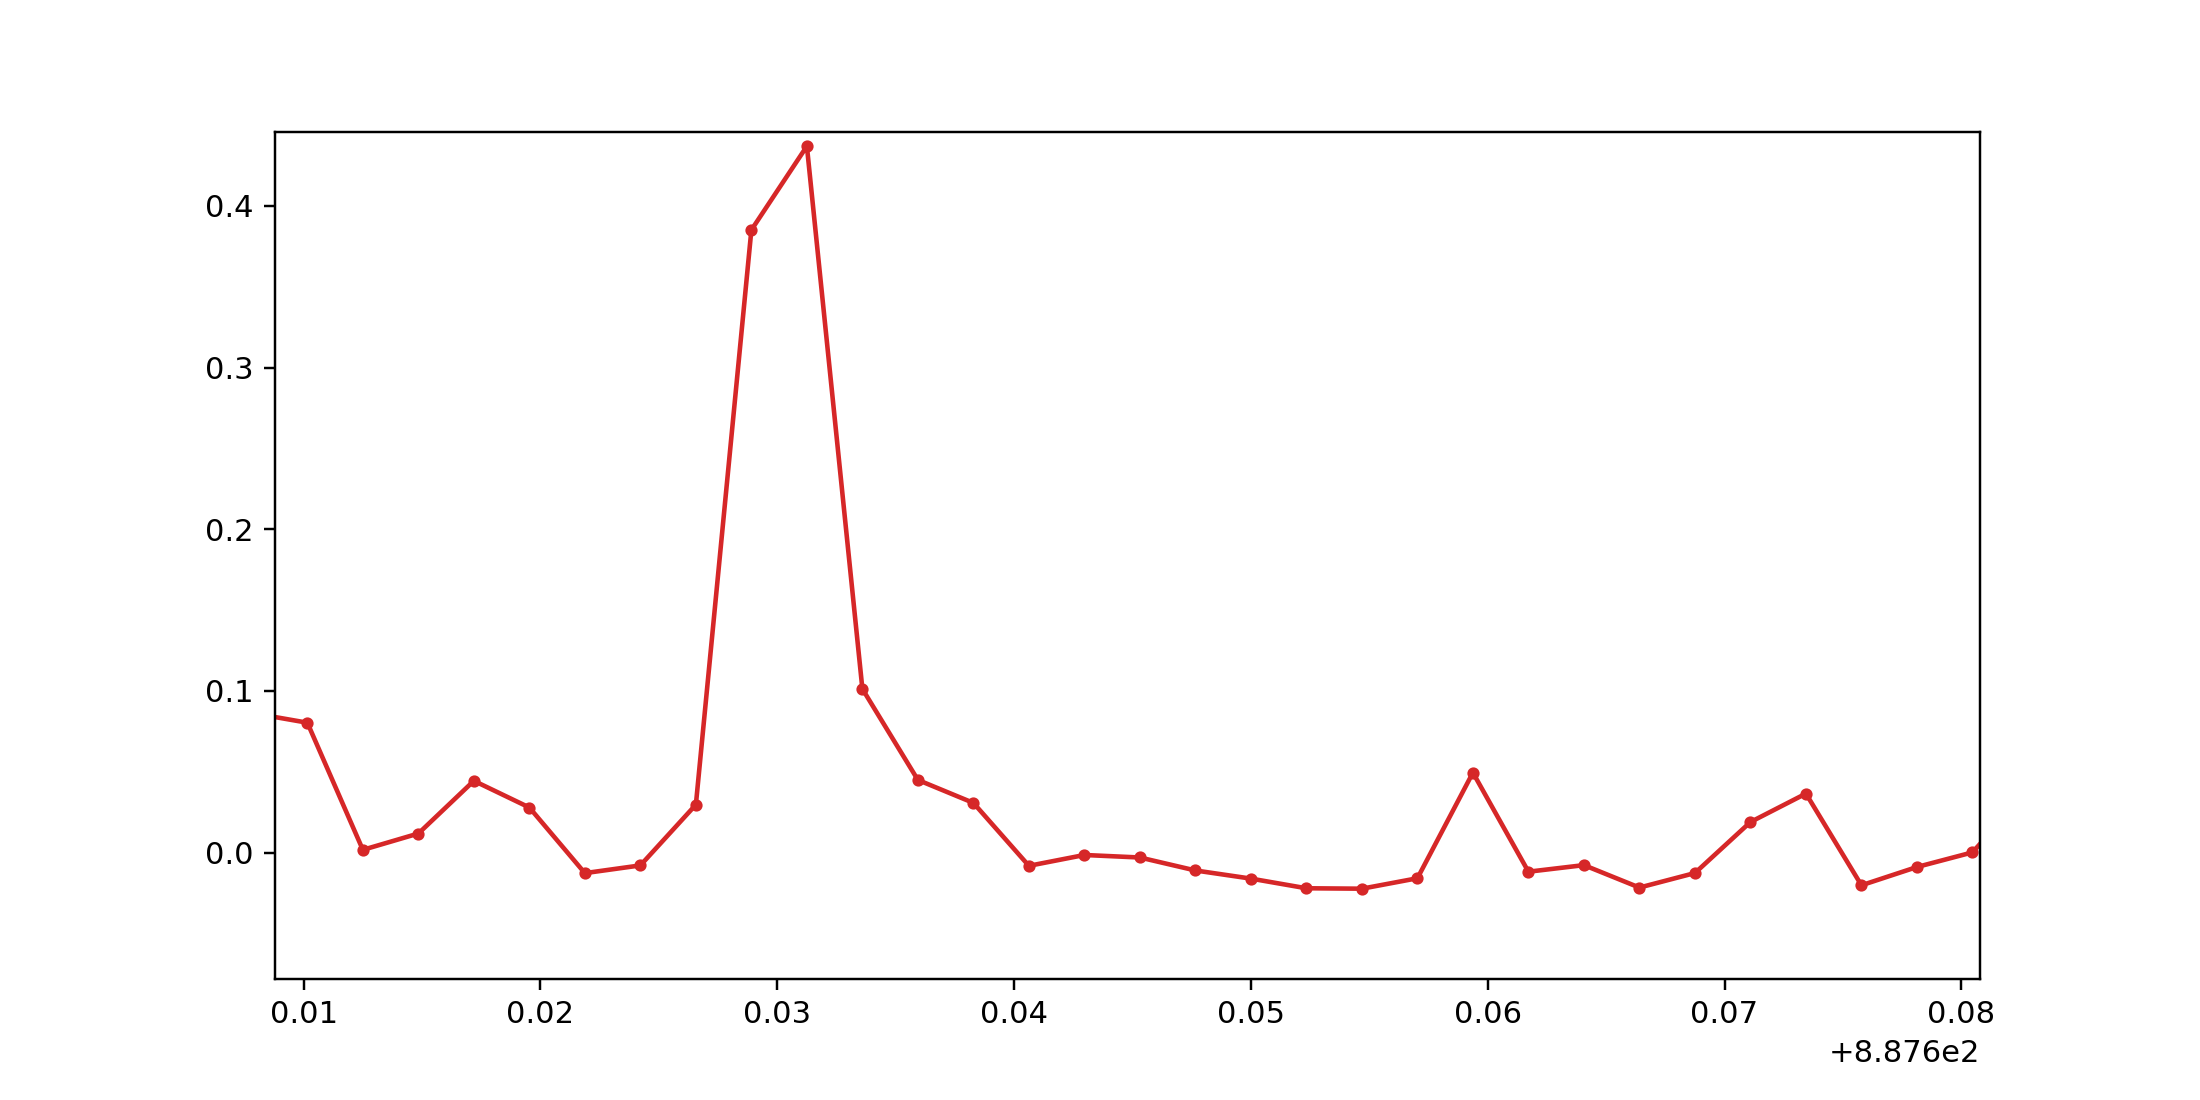

/Users/jaguirre/opt/anaconda3/envs/MRT/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [25]:
# See if there's anything characteristic by chunk
plt.figure(figsize=(10,5))
plt.plot(freq_array,np.log10(psd_array/bp_array/flags_array),'.-')
#plt.xlim([740,760])
plt.show()

In [18]:
thresh = 1.1
wh_bad_freqs = 10.*np.log10(psd_all/flags_all) > thresh
bad_freqs = freq_all[wh_bad_freqs]

/Users/jaguirre/opt/anaconda3/envs/MRT/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


In [19]:
flags_all_better = flags_all.copy()
flags_all_better[wh_bad_freqs] = 0.

/Users/jaguirre/opt/anaconda3/envs/MRT/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in true_divide
  """


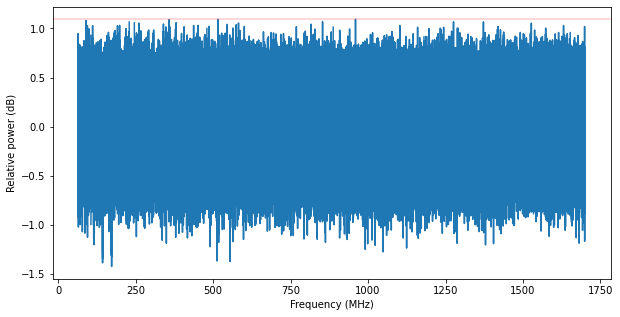

In [20]:
#%%
plt.figure(figsize=(10,5))
plt.clf()
#plt.plot(freq_all,10.*np.log10(psd_all/flags_all))
plt.plot(freq_all,10.*np.log10(psd_all/flags_all_better))
#for wtf in bad_freqs:
#    plt.axvline(wtf, color='gray', alpha=0.2)
plt.axhline(thresh, color='red', alpha=0.2)

plt.xlabel('Frequency (MHz)')
plt.ylabel('Relative power (dB)')
#plt.ylim([-2.5, 28])
#tm = time.ctime().replace(' ','_')
#plt.savefig('SDRFrequencyScan_'+tm+'.png')


plt.show()

In [21]:
np.savez('bad_freqs.npz', bad_freqs=bad_freqs)
np.savez('wh_bad_freqs.npz', wh_bad_freqs=wh_bad_freqs)
np.savez('flags_all.npz', flags_all = flags_all_better)